In [205]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

from tabulate import tabulate
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree, cophenet
from scipy.stats import skew, kurtosis, normaltest, shapiro, probplot, boxcox
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist


# Загрузка данных
data = pd.read_csv('Wholesale customers data.csv')
df = data.copy()

Дескриптивный анализ

In [206]:
# Размерность и типы признаков
print("Размерность данных:", df.shape)
print("Информация по признакам:")
df.info()

# Статистическое описание
print(df.describe().T)

# Удаляем категориальные признаки, не влияющие на кластеризацию
df.drop(['Region', 'Channel'], axis=1, inplace=True)


Размерность данных: (440, 8)
Информация по признакам:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
                  count          mean           std   min      25%     50%  \
Channel           440.0      1.322727      0.468052   1.0     1.00     1.0   
Region            440.0      2.543182      0.774272   1.0     2.00     3.0   
Fresh             440.0  12000.297727  12647.328865   3.0  3127.75  8504.0   
Milk              440.0   5796.265909   7

Оценка распределения переменных

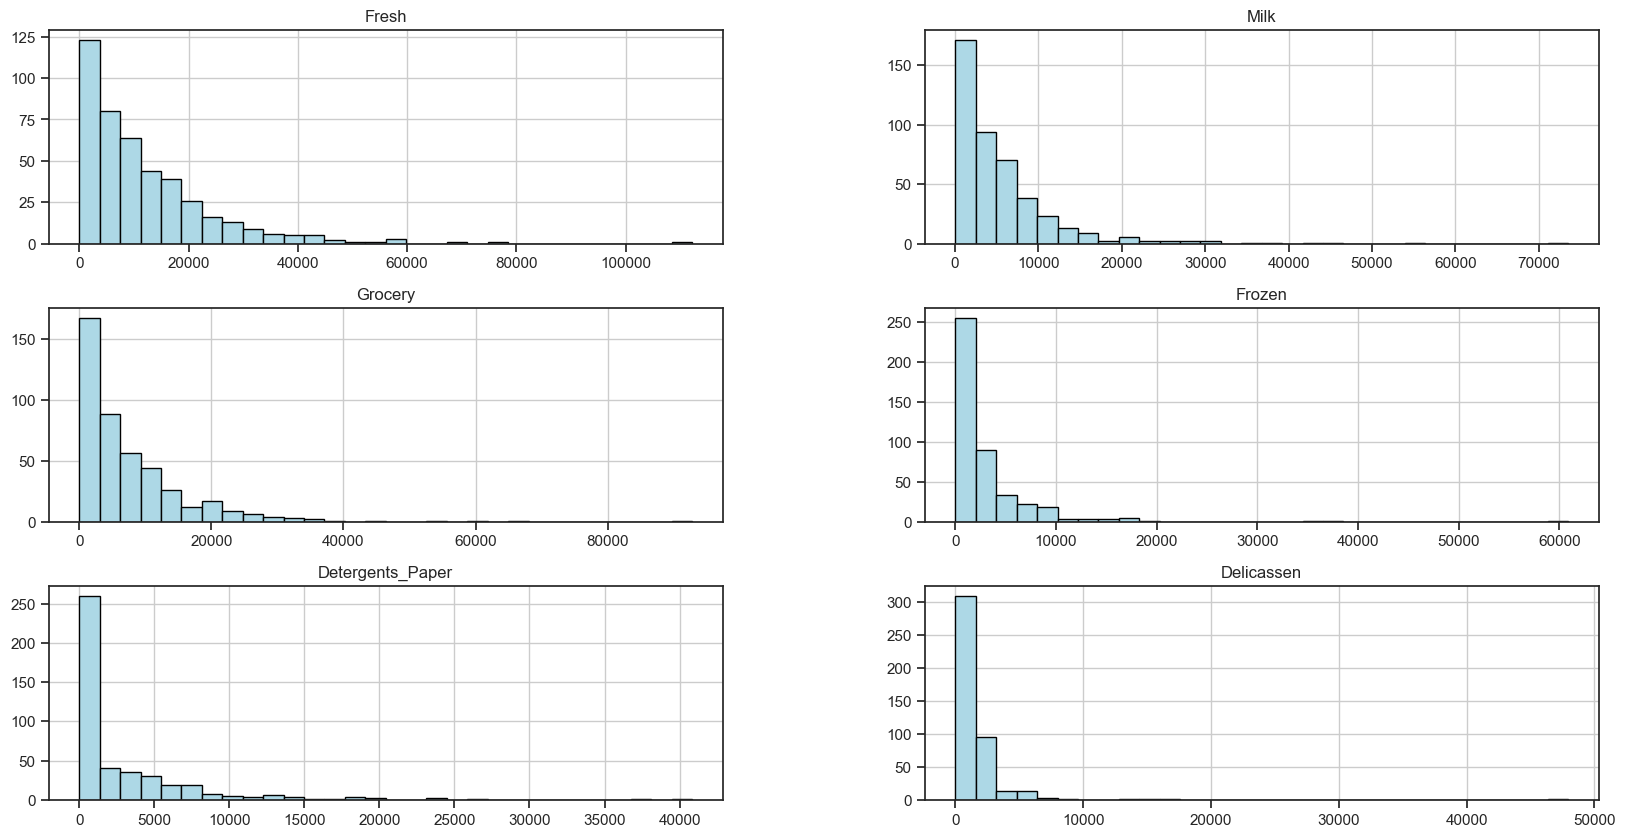

+------------------+--------------+----------------------+---------------+----------------------+--------------------+
|     Variable     | Shapiro Test | Skewness Coefficient |   Skewness    | Kurtosis Coefficient |      Kurtosis      |
+------------------+--------------+----------------------+---------------+----------------------+--------------------+
|      Fresh       |      No      |        2.5613        | Highly skewed |       11.5364        | Very flat or sharp |
|       Milk       |      No      |        4.0538        | Highly skewed |       24.6694        | Very flat or sharp |
|     Grocery      |      No      |        3.5874        | Highly skewed |       20.9147        | Very flat or sharp |
|      Frozen      |      No      |        5.9080        | Highly skewed |       54.6893        | Very flat or sharp |
| Detergents_Paper |      No      |        3.6319        | Highly skewed |       19.0095        | Very flat or sharp |
|    Delicassen    |      No      |       11.151

In [207]:
# Гистограммы
df.hist(figsize=(20,10), bins=30, color='lightblue', edgecolor='black')
plt.show()

# Тесты нормальности и показатели асимметрии и куртоза
skewness = df.skew()
kurtosisness = df.kurtosis()

headers = ['Variable', 'Shapiro Test', 'Skewness Coefficient', 'Skewness', 'Kurtosis Coefficient', 'Kurtosis']

table_data = []
for col in df.columns:
    stat, p = normaltest(df[col])
    skewness_val = f'{skewness[col]:.4f}'
    skewness_desc = 'Highly skewed' if skewness[col] < -1 or skewness[col] > 1 else 'Symmetric or mildly skewed'
    kurtosis_val = f'{kurtosisness[col]:.4f}'
    kurtosis_desc = 'Very flat or sharp' if kurtosisness[col] < -2 or kurtosisness[col] > 2 else 'Normal or mildly flat'

    stat_sh, p_sh = shapiro(df[col])
    shapiro_test = 'Yes' if p_sh >= 0.05 else 'No'
    
    table_data.append([col, shapiro_test, skewness_val, skewness_desc, kurtosis_val, kurtosis_desc])

table = tabulate(table_data, headers, tablefmt='pretty')
print(table)

Логарифмическое преобразование для уменьшения асимметрии

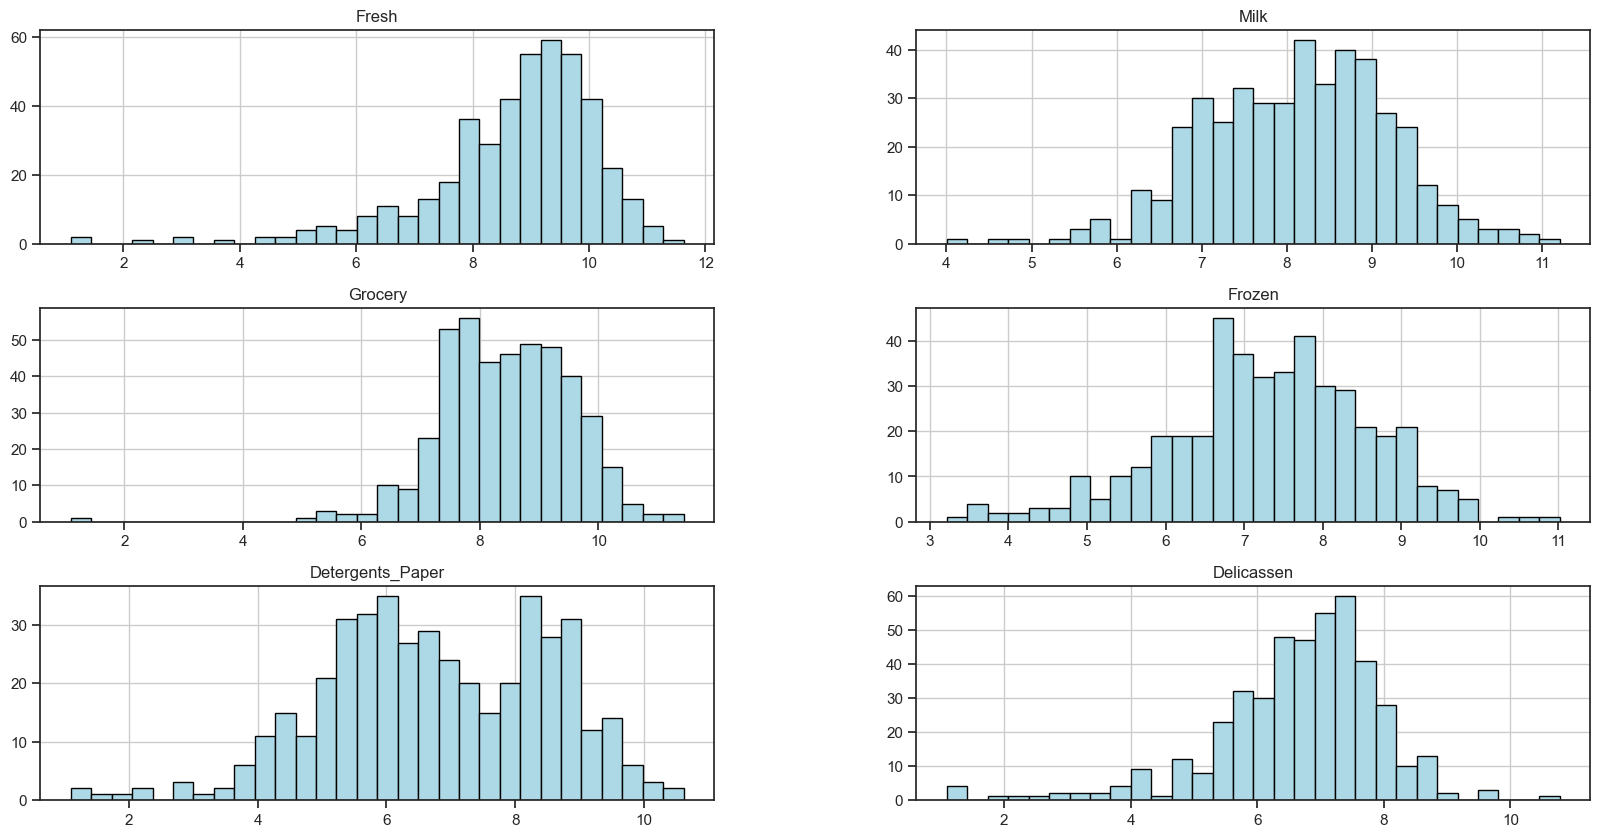

In [208]:
df = np.log(df)
df.hist(figsize=(20,10), bins=30, color='lightblue', edgecolor='black')
plt.show()

Оценка изменчивости признаков

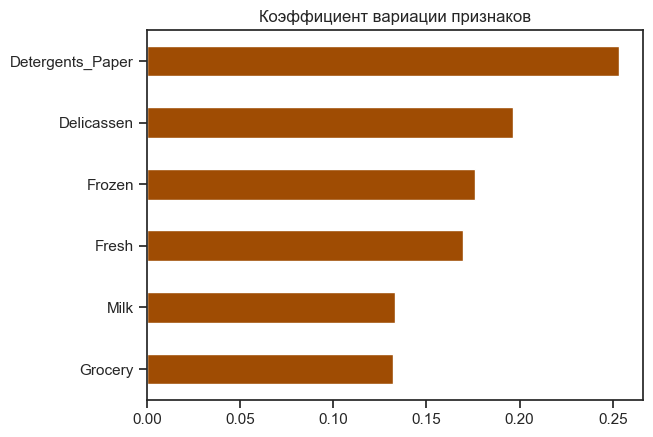

In [209]:
variability_coefficient = df.std() / df.mean()
sorted_vc = variability_coefficient.sort_values()
sorted_vc.plot.barh(x='Variables', y='Variability Coefficient')
plt.title("Коэффициент вариации признаков")
plt.show()

Проверка выбросов и корреляций

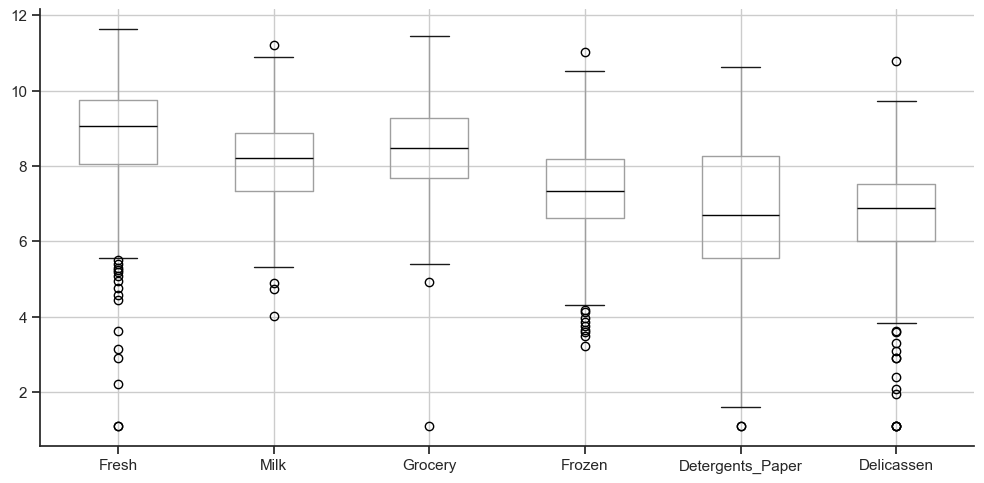

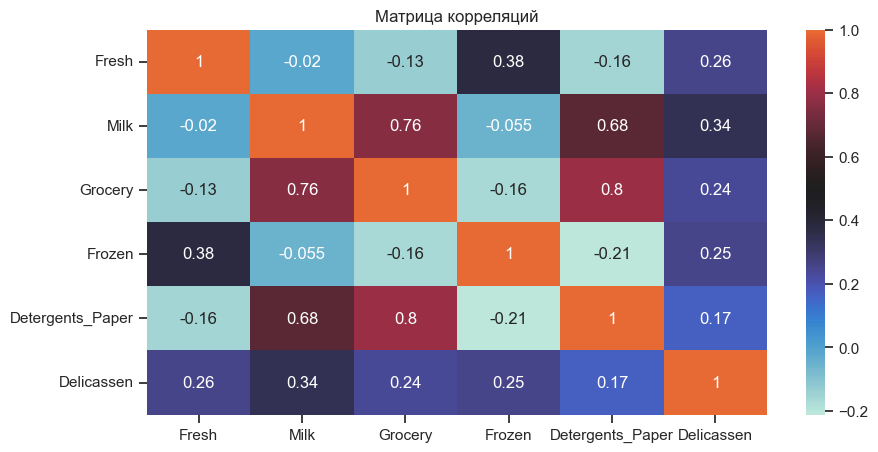

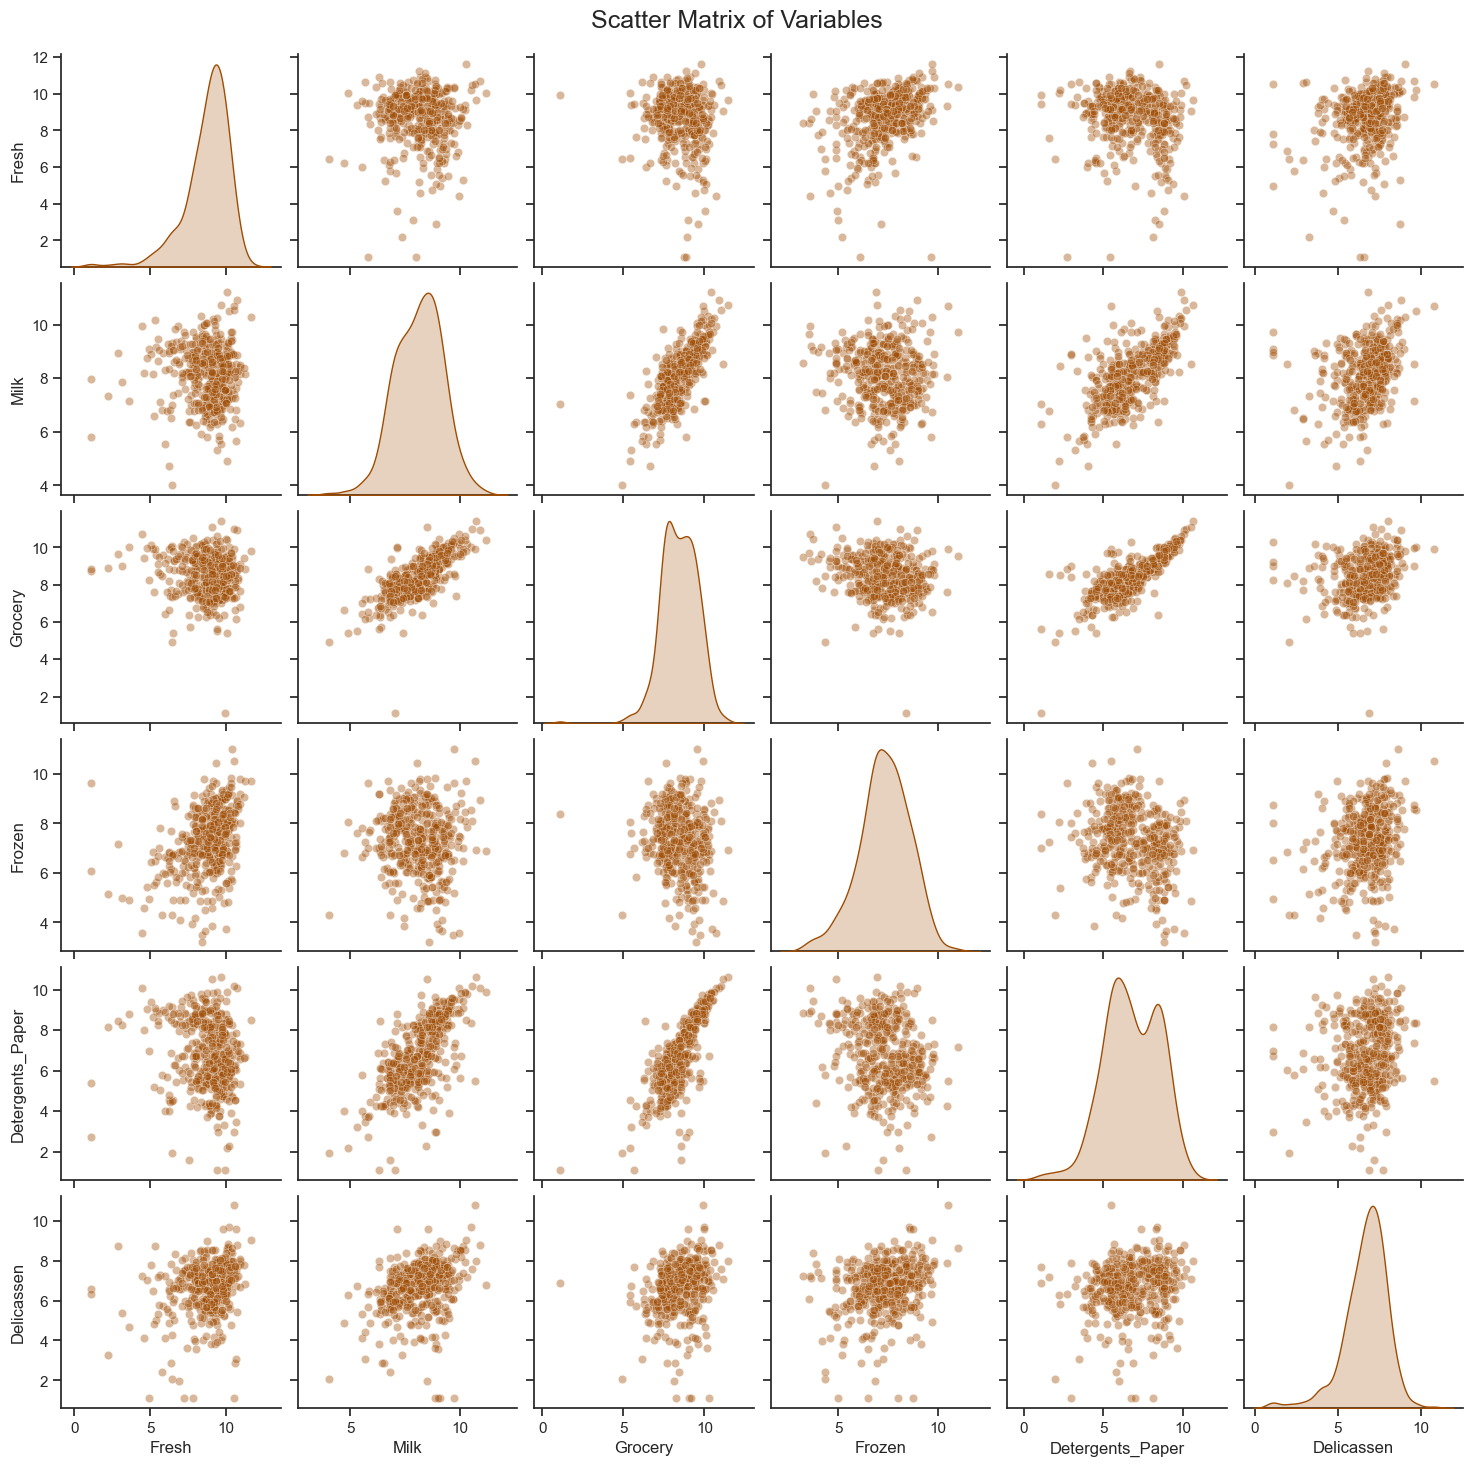

In [210]:
# Boxplot для визуальной оценки выбросов
plt.figure(figsize=(10,5))
df.boxplot()
sns.despine()
plt.tight_layout()
plt.show()

# Матрица корреляций
corr = df.corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr, center=0.5, annot=True)
plt.title('Матрица корреляций')
plt.show()

# Scatter Matrix для визуальной оценки структуры данных
sns.set(style='ticks', palette=sns.color_palette(["#9f4c03"]))
scatter_matrix = sns.pairplot(df, diag_kind='kde', markers='o', plot_kws={'alpha':0.4})
plt.subplots_adjust(top=0.95)
scatter_matrix.fig.suptitle('Scatter Matrix of Variables', fontsize=18)
plt.show()

Выбросы

Fresh (16 выбросов): [4.44265126 2.19722458 5.38907173 1.09861229 3.13549422 4.94164242
 5.29831737 5.19295685 2.89037176 5.08140436 5.49306144 1.09861229
 4.76217393 5.24702407 3.61091791 4.57471098]
Milk (4 выбросов): [11.20501347  4.71849887  4.00733319  4.8978398 ]
Grocery (2 выбросов): [1.09861229 4.91998093]
Frozen (10 выбросов): [ 3.49650756  3.63758616  3.58351894  3.73766962  3.95124372  4.11087386
 11.01647929  3.21887582  3.8501476   4.17438727]
Detergents_Paper (2 выбросов): [1.09861229 1.09861229]
Delicassen (14 выбросов): [ 3.29583687  1.09861229  1.09861229  3.58351894  1.09861229  2.07944154
 10.77776808  2.39789527  1.09861229  2.89037176  1.94591015  2.89037176
  3.09104245  3.61091791]


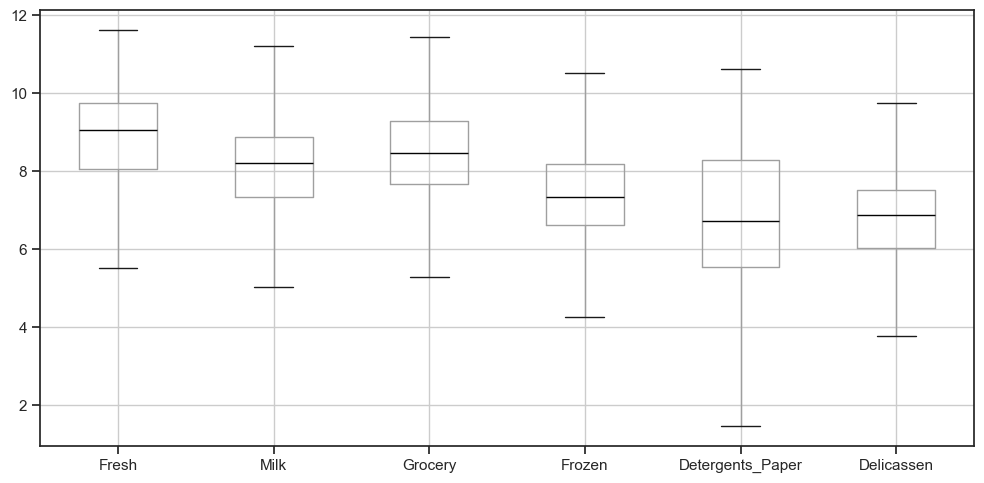

In [211]:
outliers = {}
for col in df.columns:
    q25, q75 = np.percentile(df[col], [25,75])
    iqr = q75 - q25
    lower_bound = q25 - iqr*1.5
    upper_bound = q75 + iqr*1.5
    outlier_values = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    if not outlier_values.empty:
        outliers[col] = outlier_values.values

for col, values in outliers.items():
    print(f'{col} ({len(values)} выбросов): {values}')

# удаление выбросов
for i in df.keys():
    q25, q75 = np.percentile(df[i], [25,75])
    iqr = q75 - q25
    lower_bound = q25 - iqr*1.5
    upper_bound = q75 + iqr*1.5
    df.loc[df[i] < lower_bound, i] = lower_bound
    df.loc[df[i] > upper_bound, i] = upper_bound

plt.figure(figsize=(10,5))
df.boxplot()
plt.tight_layout()
plt.show()

Проверка пропусков и дубликатов

In [212]:
print("Пропущенные значения по столбцам:\n", df.isnull().sum())
print("Количество дубликатов:", df.duplicated().sum())

Пропущенные значения по столбцам:
 Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64
Количество дубликатов: 0


Стандартизация данных

In [213]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

K-Means

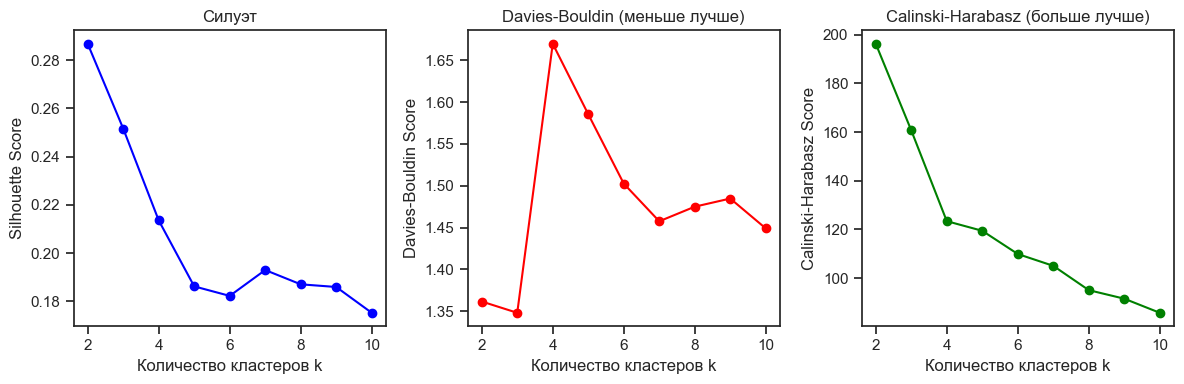

Оптимальное k по Silhouette: 2
Оптимальное k по Davies-Bouldin: 3
Оптимальное k по Calinski-Harabasz: 2


In [218]:
# Диапазон количества кластеров для исследования
k_range = range(2, 11)

# Списки для хранения метрик
sil_scores = []
db_scores = []
ch_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(df_scaled)
    
    sil_scores.append(silhouette_score(df_scaled, labels))
    db_scores.append(davies_bouldin_score(df_scaled, labels))
    ch_scores.append(calinski_harabasz_score(df_scaled, labels))

# Визуализация зависимости метрик от k
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(k_range, sil_scores, 'o-', color='blue')
plt.xlabel('Количество кластеров k')
plt.ylabel('Silhouette Score')
plt.title('Силуэт')

plt.subplot(1,3,2)
plt.plot(k_range, db_scores, 'o-', color='red')
plt.xlabel('Количество кластеров k')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin (меньше лучше)')

plt.subplot(1,3,3)
plt.plot(k_range, ch_scores, 'o-', color='green')
plt.xlabel('Количество кластеров k')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz (больше лучше)')

plt.tight_layout()
plt.show()

# Оптимальное k по метрикам
best_sil = k_range[sil_scores.index(max(sil_scores))]
best_db = k_range[db_scores.index(min(db_scores))]
best_ch = k_range[ch_scores.index(max(ch_scores))]

print(f"Оптимальное k по Silhouette: {best_sil}")
print(f"Оптимальное k по Davies-Bouldin: {best_db}")
print(f"Оптимальное k по Calinski-Harabasz: {best_ch}")

Оптимальное количество кластеров: 2


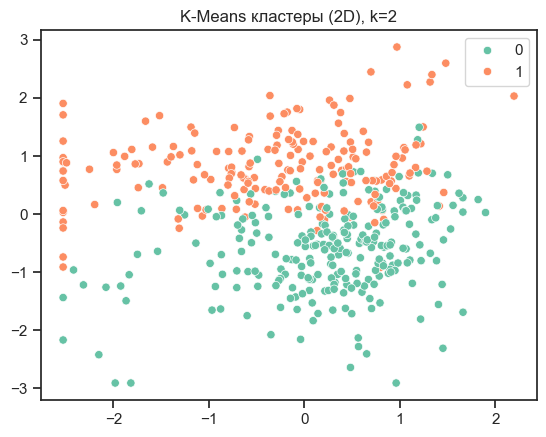

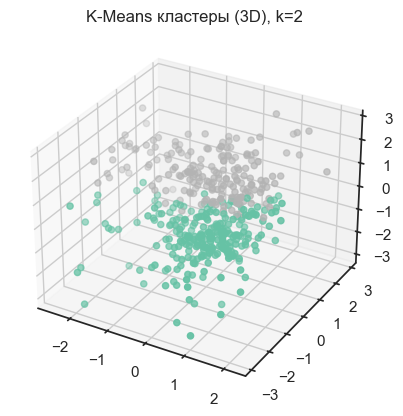

In [219]:
optimal_k = 2
print(f"Оптимальное количество кластеров: {optimal_k}")

# K-Means с оптимальным k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(df_scaled)
labels_kmeans = kmeans.labels_
centers = kmeans.cluster_centers_

# Визуализация кластеров в 2D
sns.scatterplot(x=df_scaled[:,0], y=df_scaled[:,1], hue=labels_kmeans, palette='Set2')
plt.title(f"K-Means кластеры (2D), k={optimal_k}")
plt.show()

# Визуализация кластеров в 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_scaled[:,0], df_scaled[:,1], df_scaled[:,2], c=labels_kmeans, cmap='Set2')
plt.title(f"K-Means кластеры (3D), k={optimal_k}")
plt.show()


Gaussian Mixture

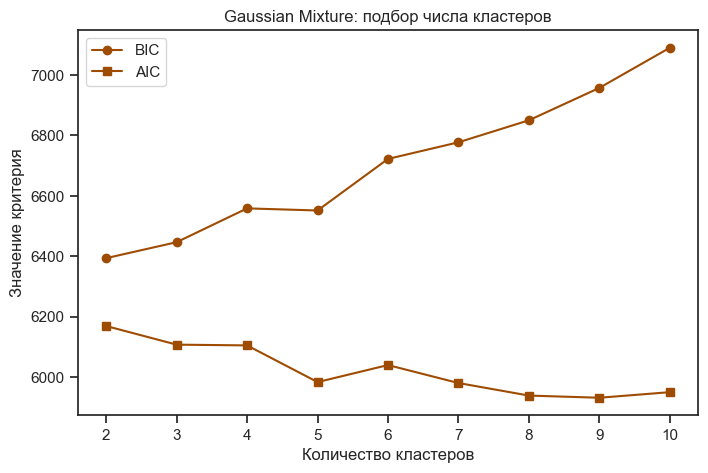

Оптимальное количество кластеров для GMM: 2


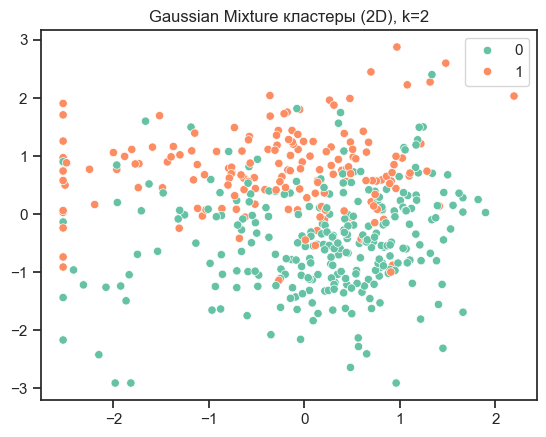

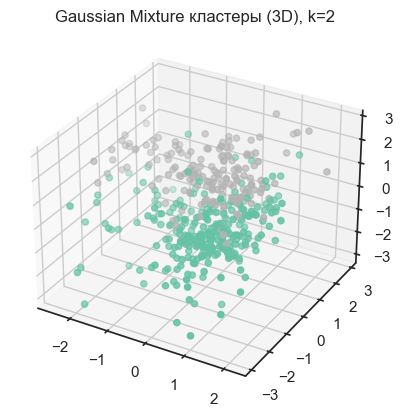

In [215]:
# Подбор оптимального числа кластеров с помощью BIC/AIC
n_components = range(2, 11)
bic_scores = []
aic_scores = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(df_scaled)
    bic_scores.append(gmm.bic(df_scaled))
    aic_scores.append(gmm.aic(df_scaled))

# Визуализация BIC и AIC
plt.figure(figsize=(8,5))
plt.plot(n_components, bic_scores, label='BIC', marker='o')
plt.plot(n_components, aic_scores, label='AIC', marker='s')
plt.xlabel('Количество кластеров')
plt.ylabel('Значение критерия')
plt.title('Gaussian Mixture: подбор числа кластеров')
plt.legend()
plt.show()

# Оптимальное количество кластеров выбираем по минимальному BIC
optimal_gmm_k = n_components[np.argmin(bic_scores)]
print(f"Оптимальное количество кластеров для GMM: {optimal_gmm_k}")

# Кластеризация с оптимальным числом кластеров
gmm = GaussianMixture(n_components=optimal_gmm_k, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(df_scaled)

# Визуализация кластеров в 2D
sns.scatterplot(x=df_scaled[:,0], y=df_scaled[:,1], hue=gmm_labels, palette='Set2')
plt.title(f"Gaussian Mixture кластеры (2D), k={optimal_gmm_k}")
plt.show()

# Визуализация кластеров в 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_scaled[:,0], df_scaled[:,1], df_scaled[:,2], c=gmm_labels, cmap='Set2')
plt.title(f"Gaussian Mixture кластеры (3D), k={optimal_gmm_k}")
plt.show()


Оценка качества кластеризации

In [216]:
print("Внутренние метрики")

# K-Means
sil_kmeans = silhouette_score(df_scaled, labels_kmeans)
db_kmeans = davies_bouldin_score(df_scaled, labels_kmeans)
ch_kmeans = calinski_harabasz_score(df_scaled, labels_kmeans)
print(f"\nK-Means: Silhouette={sil_kmeans:.3f}, Davies-Bouldin={db_kmeans:.3f}, Calinski-Harabasz={ch_kmeans:.3f}")

# Gaussian Mixture
sil_gmm = silhouette_score(df_scaled, gmm_labels)
db_gmm = davies_bouldin_score(df_scaled, gmm_labels)
ch_gmm = calinski_harabasz_score(df_scaled, gmm_labels)
print(f"\nGMM: Silhouette={sil_gmm:.3f}, Davies-Bouldin={db_gmm:.3f}, Calinski-Harabasz={ch_gmm:.3f}")

# Центры кластеров (K-Means)
centers_orig = scaler.inverse_transform(centers)
centers_df = pd.DataFrame(centers_orig, columns=df.columns)
print("\nЦентры кластеров K-Means:")
print(centers_df)

# Расстояния между кластерами (для K-Means)
centers = kmeans.cluster_centers_
dist_matrix = cdist(centers, centers)
print("\nРасстояния между центрами кластеров K-Means:")
print(np.round(dist_matrix, 2))

# Внутрикластерные расстояния (среднее расстояние от точек до центра)
intra_distances = []
for i in range(optimal_k):
    points = df_scaled[labels_kmeans == i]
    center = centers[i]
    intra_dist = np.mean(np.linalg.norm(points - center, axis=1))
    intra_distances.append(intra_dist)

print("\nСредние внутрикластерные расстояния K-Means:")
for i, d in enumerate(intra_distances):
    print(f"Кластер {i}: {d:.3f}")


# GMM
gmm_centers = gmm.means_
gmm_centers_orig = scaler.inverse_transform(gmm_centers)
gmm_centers_df = pd.DataFrame(gmm_centers_orig, columns=df.columns)
print("\nЦентры кластеров GMM:")
print(gmm_centers_df)

# Расстояния между центрами GMM
dist_matrix_gmm = cdist(gmm_centers, gmm_centers)
print("\nРасстояния между центрами кластеров GMM:")
print(np.round(dist_matrix_gmm, 2))

# Внутрикластерные расстояния для GMM
intra_distances_gmm = []
for i in range(gmm.n_components):
    points = df_scaled[gmm_labels == i]
    center = gmm_centers[i]
    intra_dist = np.mean(np.linalg.norm(points - center, axis=1))
    intra_distances_gmm.append(intra_dist)

print("\nСредние внутрикластерные расстояния GMM:")
for i, d in enumerate(intra_distances_gmm):
    print(f"Кластер {i}: {d:.3f}")

Внутренние метрики

K-Means: Silhouette=0.287, Davies-Bouldin=1.361, Calinski-Harabasz=196.293

GMM: Silhouette=0.263, Davies-Bouldin=1.410, Calinski-Harabasz=171.584

Центры кластеров K-Means:
      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
0  9.074036  7.473857  7.745980  7.641763          5.668188    6.498763
1  8.396600  8.996112  9.397129  6.866920          8.288110    6.982801

Расстояния между центрами кластеров K-Means:
[[0.   2.75]
 [2.75 0.  ]]

Средние внутрикластерные расстояния K-Means:
Кластер 0: 1.815
Кластер 1: 1.935

Центры кластеров GMM:
      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
0  9.017409  7.649388  7.880203  7.644600          5.732947    6.582865
1  8.405614  8.897260  9.381337  6.767186          8.504309    6.905323

Расстояния между центрами кластеров GMM:
[[0.  2.6]
 [2.6 0. ]]

Средние внутрикластерные расстояния GMM:
Кластер 0: 1.947
Кластер 1: 1.827


PCA-визуализация

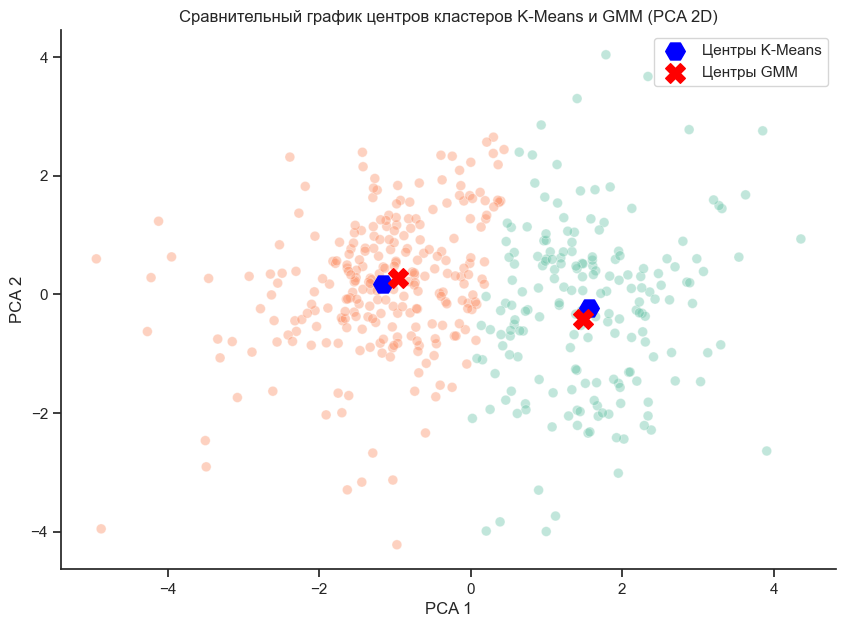

In [ ]:
custom_palette = sns.color_palette(["#9f4c03"])
sns.set(style='ticks', palette=custom_palette)

# PCA для визуализации
pca = PCA(n_components=2)
pca_df = pca.fit_transform(df_scaled)

# K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_df)
kmeans_centers = kmeans.cluster_centers_

# GMM
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(pca_df)
gmm_centers = gmm.means_

# Визуализация
plt.figure(figsize=(10,7))

# Точки данных по K-Means
sns.scatterplot(x=pca_df[:,0], y=pca_df[:,1], hue=kmeans_labels, palette='Set2', alpha=0.4, s=50, legend=False)

# Центры K-Means
plt.scatter(kmeans_centers[:,0], kmeans_centers[:,1], marker='H', s=200, c='blue', label='Центры K-Means')

# Центры GMM
plt.scatter(gmm_centers[:,0], gmm_centers[:,1], marker='X', s=200, c='red', label='Центры GMM')

plt.title("Сравнительный график центров кластеров K-Means и GMM (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
sns.despine()
plt.show()